In [1]:
!sudo apt-get install libkrb5-dev -q

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
0 upgraded, 7 newly installed, 0 to remove and 5 not upgraded.
Need to get 349 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.2 [54.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.2 [37.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd6

In [ ]:
!pip install arcgis==1.8.4 torch==1.4.0 fastai==1.0.60 torchvision==0.5.0 -q

In [ ]:
!pip install tensorboardx==2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 35.2 MB/s 


### 1. Necessary imports

In [3]:
import os
import pandas as pd
from pathlib import Path

from arcgis.learn import RetinaNet, prepare_data

In [5]:
!ls

drive  sample_data


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Prepare data that will be used for training

### 3. Model Training

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [16]:
filepath = '/content/drive/MyDrive/vehicle_detection_and_tracking.zip'

In [17]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [18]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [19]:
data = prepare_data(data_path, 
                    batch_size=4, 
                    dataset_type="PASCAL_VOC_rectangles", 
                    chip_size=480)

In [20]:
data.classes

['background',
 'bicycle',
 'bus',
 'car',
 'motorcycle',
 'person',
 'scooter',
 'tempo',
 'tractor',
 'truck',
 'van']

### 4. Visualize training data

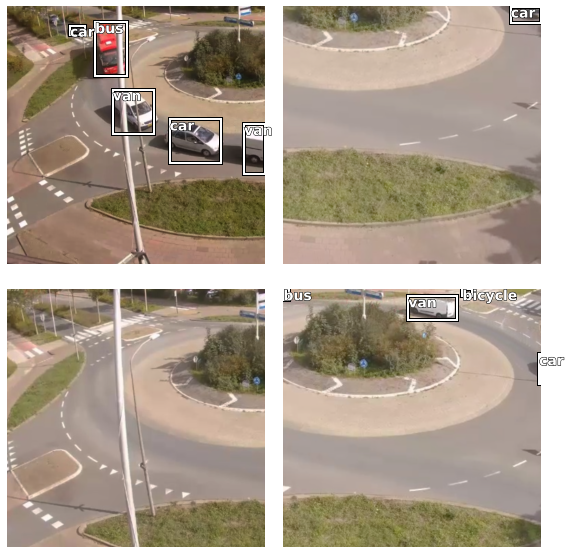

In [21]:
data.show_batch()

### 5. Load model architecture

In [13]:
retinanet = RetinaNet(data)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

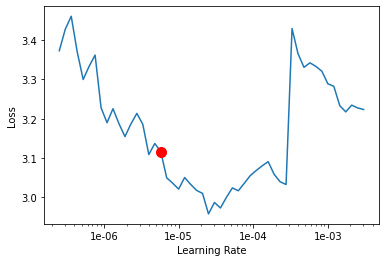

In [23]:
lr = retinanet.lr_find()

### 6. Train the model

In [24]:
retinanet.fit(2000, lr=lr, tensorboard=True)

/usr/local/lib/python3.7/dist-packages/arcgis/learn/models/_arcgis_model.py:705: UserWarning: Install tensorboardX 2.1 'pip install tensorboardx==2.1' to write training log
  warn("Install tensorboardX 2.1 'pip install tensorboardx==2.1' to write training log")


epoch,train_loss,valid_loss,time
0,2.760205,3.650501,00:18
1,2.920823,3.646339,00:17
2,2.855134,3.641513,00:17
3,2.859644,3.637185,00:16
4,2.779647,3.631757,00:17
5,2.867237,3.625339,00:16
6,2.871541,3.620244,00:17
7,2.884840,3.613706,00:17
8,2.899596,3.606121,00:17
9,2.914298,3.602138,00:17


KeyboardInterrupt: ignored

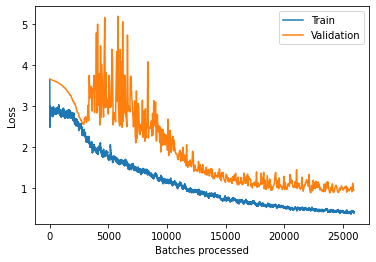

In [25]:
retinanet.learn.recorder.plot_losses()

### 7. Visualize results on validation set

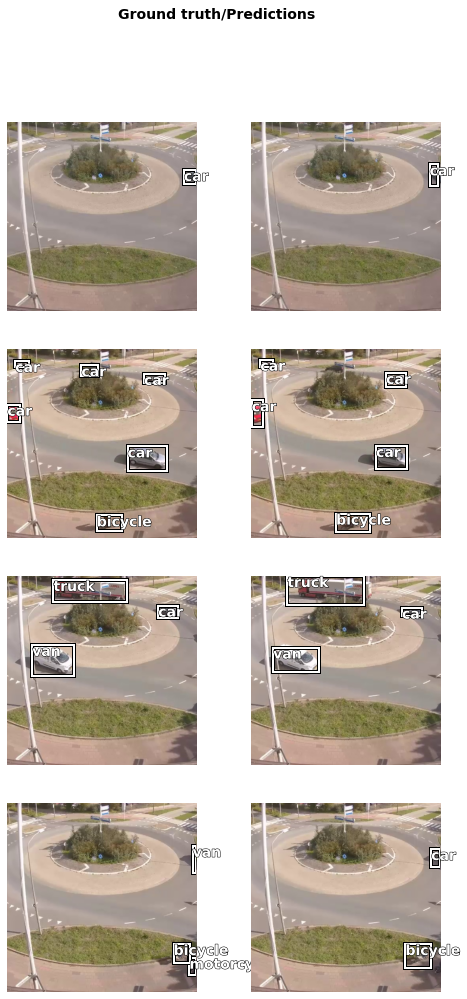

In [26]:
retinanet.show_results(thresh=0.4)

In [27]:
retinanet.average_precision_score(detect_thresh=0.4)

{'bicycle': 0.6160968781111933,
 'bus': 0.5,
 'car': 0.7667807260686601,
 'motorcycle': 0.0,
 'person': 0.0,
 'scooter': 0.0,
 'tempo': 0.0,
 'tractor': 0.0,
 'truck': 1.0,
 'van': 0.3636363744735718}

In [28]:
all_classes=[]
for i, bb in enumerate(data.train_ds.y):
    all_classes += bb.data[1].tolist()
    
df = pd.value_counts(all_classes, sort=False)
df.index = [data.classes[i] for i in df.index] 
df

car           747
van            75
bicycle       267
person         26
scooter         7
motorcycle     32
truck          29
bus            23
tempo           1
tractor         3
dtype: int64

### 8. Save the model

In [29]:
retinanet.save('vehicle_det_ep508_defaults')

Computing model metrics...


PosixPath('/content/drive/MyDrive/vehicle_detection_and_tracking/models/vehicle_det_ep508_defaults')

### 9. Inference and tracking

In [30]:
videopath = '/content/vehicle_detection_and_tracking_video.zip'

In [31]:
import zipfile
with zipfile.ZipFile(videopath, 'r') as zip_ref:
    zip_ref.extractall(Path(videopath).parent)

In [32]:
video_file = os.path.join(os.path.splitext(videopath)[0], 'test.mp4')

In [33]:
retinanet.predict_video(input_video_path=video_file, 
                        metadata_file='test.csv',
                        track=True, 
                        visualize=True, 
                        threshold=0.5,
                        resize=True)